## All stations models

In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import re
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
# %run model_utils.ipynb

In [4]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

In [5]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv',
         'cunchibamba':'cunchibamba-hgpt_validation.csv'
         }
## cuchimbamba??

In [6]:
def selectCols(df):
  d = dict(zip(df.columns[1:20],df.columns[1:20]+f'_{station[0:3]}'))
  #df = df[['Date_Time', 'ATAvg', 'RHAvg','WDAvg','WSAvg','WAvgx', 'WAvgy','Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]
  df = df[['Date_Time', 'ATAvg', 'RHAvg','WSAvg','WAvgx','Day_sin', 'Day_cos']]
  df.rename(columns=d, inplace= True)
  df.set_index('Date_Time', inplace =True)
  df.index = pd.to_datetime(df.index)
  return df

In [7]:
### combine all stations in one df
for idx, station in enumerate(files_ids.keys()):
    if idx == 0:
        df = pd.read_csv(f'{input_path}/{station}_validation.csv')
        merged = selectCols(df)
    else:
        df1 = pd.read_csv(f'{input_path}/{station}_validation.csv')
        df1 = selectCols(df1)
        merged=pd.merge(merged,df1, how='inner', left_index=True, right_index=True)
    

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
merged.columns

Index(['ATAvg_gua', 'RHAvg_gua', 'WSAvg_gua', 'WAvgx_gua', 'Day_sin_gua',
       'Day_cos_gua', 'ATAvg_ban', 'RHAvg_ban', 'WSAvg_ban', 'WAvgx_ban',
       'Day_sin_ban', 'Day_cos_ban', 'ATAvg_aer', 'RHAvg_aer', 'WSAvg_aer',
       'WAvgx_aer', 'Day_sin_aer', 'Day_cos_aer', 'ATAvg_qui', 'RHAvg_qui',
       'WSAvg_qui', 'WAvgx_qui', 'Day_sin_qui', 'Day_cos_qui', 'ATAvg_chi',
       'RHAvg_chi', 'WSAvg_chi', 'WAvgx_chi', 'Day_sin_chi', 'Day_cos_chi',
       'ATAvg_AJS', 'RHAvg_AJS', 'WSAvg_AJS', 'WAvgx_AJS', 'Day_sin_AJS',
       'Day_cos_AJS', 'ATAvg_JAl', 'RHAvg_JAl', 'WSAvg_JAl', 'WAvgx_JAl',
       'Day_sin_JAl', 'Day_cos_JAl', 'ATAvg_pfc', 'RHAvg_pfc', 'WSAvg_pfc',
       'WAvgx_pfc', 'Day_sin_pfc', 'Day_cos_pfc', 'ATAvg_cal', 'RHAvg_cal',
       'WSAvg_cal', 'WAvgx_cal', 'Day_sin_cal', 'Day_cos_cal', 'ATAvg_mul',
       'RHAvg_mul', 'WSAvg_mul', 'WAvgx_mul', 'Day_sin_mul', 'Day_cos_mul',
       'ATAvg_pam', 'RHAvg_pam', 'WSAvg_pam', 'WAvgx_pam', 'Day_sin_pam',
       'Day_cos_pam', 

In [9]:
merged.head()

,ATAvg_gua,RHAvg_gua,WSAvg_gua,WAvgx_gua,Day_sin_gua,Day_cos_gua,ATAvg_ban,RHAvg_ban,WSAvg_ban,WAvgx_ban,...,WSAvg_pis,WAvgx_pis,Day_sin_pis,Day_cos_pis,ATAvg_cun,RHAvg_cun,WSAvg_cun,WAvgx_cun,Day_sin_cun,Day_cos_cun
Date_Time,,,,,,,,,,,,,,,,,,,,,
2013-05-09 11:45:00,21.708,55.150,4.195,-4.191908,6.540313e-02,-0.997859,23.982,61.768,4.765,-0.759371,...,4.63,-3.217721,6.540313e-02,-0.997859,17.55,64.24,4.21,-2.411445,6.540313e-02,-0.997859
2013-05-09 11:50:00,21.728,53.284,4.195,-4.191908,4.361939e-02,-0.999048,24.292,60.124,4.765,-0.759371,...,4.02,-2.793788,4.361939e-02,-0.999048,17.59,62.67,4.22,-2.417173,4.361939e-02,-0.999048
2013-05-09 11:55:00,22.090,51.676,4.195,-4.191908,2.181489e-02,-0.999762,24.532,59.028,4.765,-0.759371,...,4.36,-3.030079,2.181489e-02,-0.999762,17.69,63.43,4.29,-2.457268,2.181489e-02,-0.999762
2013-05-09 12:00:00,22.190,51.590,4.630,-4.629973,1.373671e-12,-1.000000,24.454,59.820,5.060,-0.907346,...,5.79,-3.925430,1.373671e-12,-1.000000,17.74,65.67,4.16,-2.545388,1.373671e-12,-1.000000
2013-05-09 12:05:00,22.106,50.402,4.630,-4.629973,-2.181489e-02,-0.999762,24.580,59.690,5.060,-0.907346,...,6.03,-4.088142,-2.181489e-02,-0.999762,17.85,64.45,4.20,-2.569863,-2.181489e-02,-0.999762


In [10]:
print(f'len = {len(merged)}')
merged.drop_duplicates(keep = 'first',inplace=True)
print(f'len (after duplicate drop = {len(merged)}')

len = 623263
len (after duplicate drop = 623263


In [11]:
merged.isnull().values.any()

False

In [12]:
#delete outliers an dfill with the meadian value
Q1 = merged.quantile(0.25)
Q3 = merged.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

ATAvg_gua       4.860000
RHAvg_gua      29.450000
WSAvg_gua       3.660000
WAvgx_gua       3.830788
Day_sin_gua     1.414214
                 ...    
RHAvg_cun      27.330000
WSAvg_cun       2.770000
WAvgx_cun       2.108025
Day_sin_cun     1.414214
Day_cos_cun     1.414214
Length: 84, dtype: float64


In [13]:
for i,col in enumerate(merged.columns):
    merged[col] = np.where((merged[col] < (Q1[i] - 1.5 * IQR[i]))|(merged[col] > (Q3[i] + 1.5 * IQR[i])), np.nan, merged[col])

In [14]:
merged.isnull().values.any()

True

In [15]:
merged['month']= merged.index.month
merged['hour']= merged.index.hour
for v in merged.columns:
    merged[v] = merged.groupby(['hour','month'])[v].transform(lambda x: x.fillna(x.median()))


In [16]:
merged.drop(columns=['month','hour'],inplace=True)

In [17]:
merged.isnull().values.any()

False

In [18]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = merged[0::steps]

In [19]:
print(f'starts at = {df.index.min().date()}')
print(f'ends at = {df.index.max().date()}')

starts at = 2013-05-09
ends at = 2019-04-12


In [20]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(df.columns))) 

In [21]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [22]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Run models

In [23]:
## read functions
%run model_utils.ipynb

In [24]:
station = 'all'
num_features = df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 32
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps
scaler_type = 'mean'

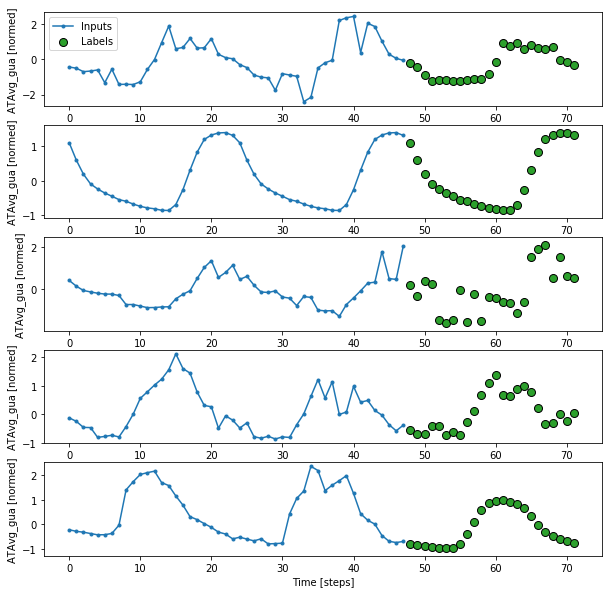

In [25]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

## 1 LSTM layer

323/323 [==============================] - 2s 6ms/step - loss: 0.3484 - mean_absolute_error: 0.3709


/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

CPU times: user 23min 51s, sys: 4min 6s, total: 27min 58s
Wall time: 14min 57s


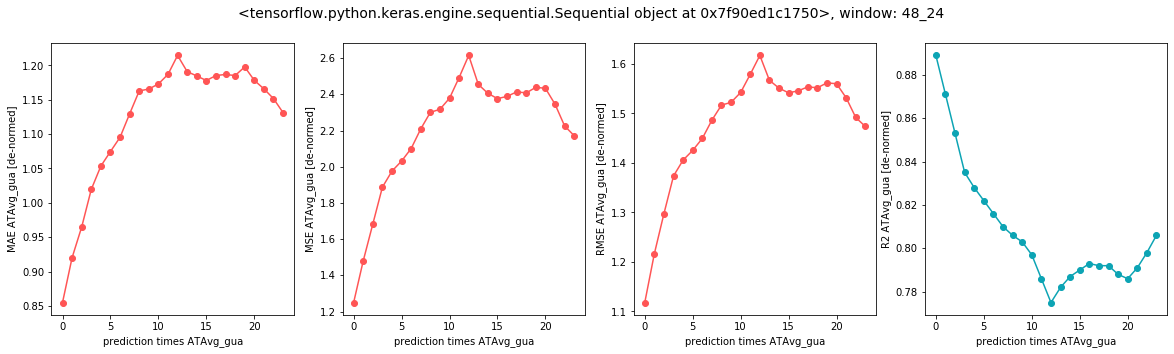

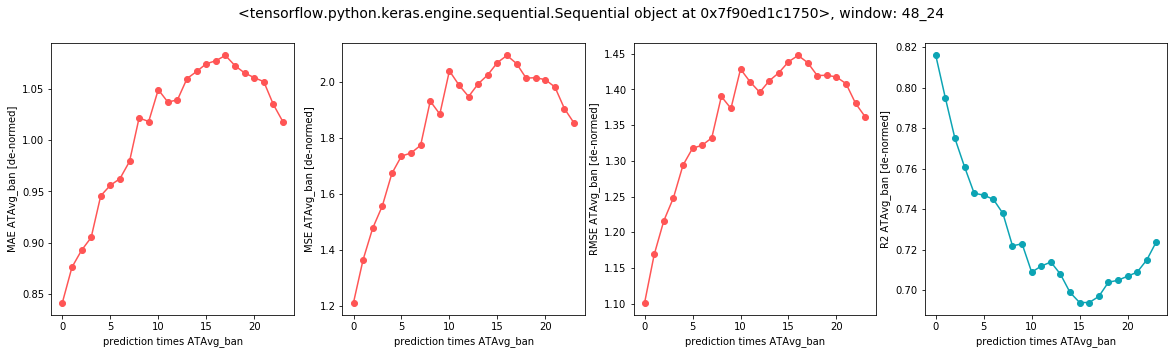

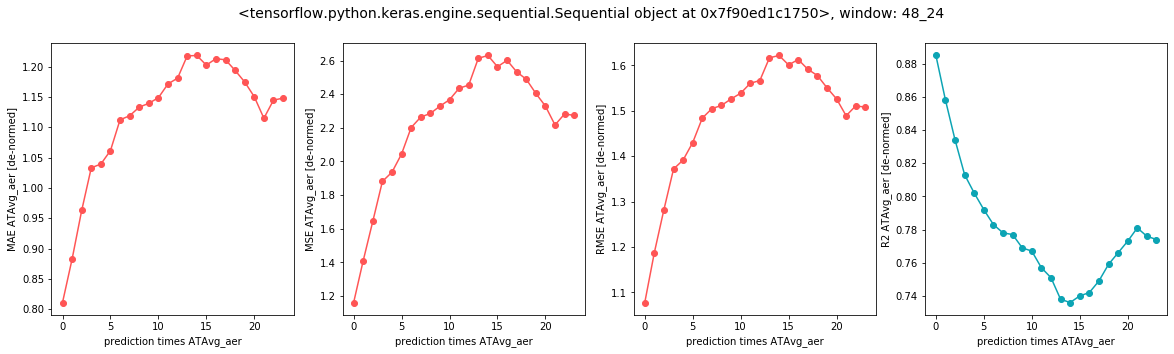

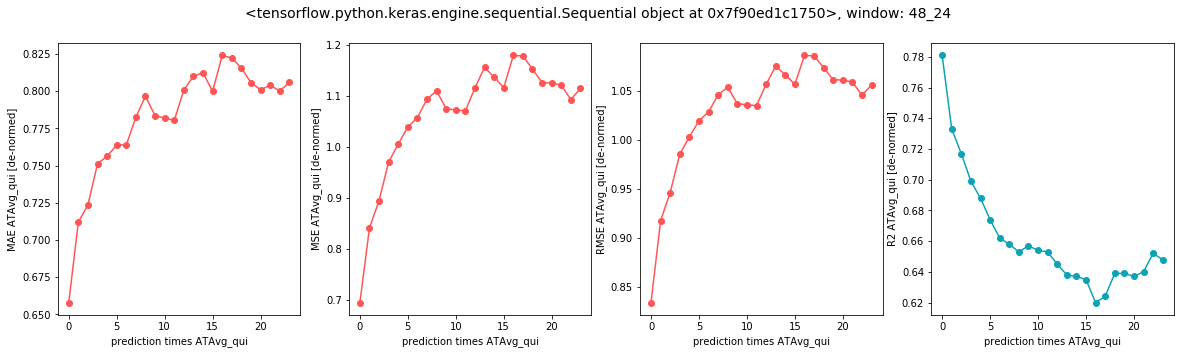

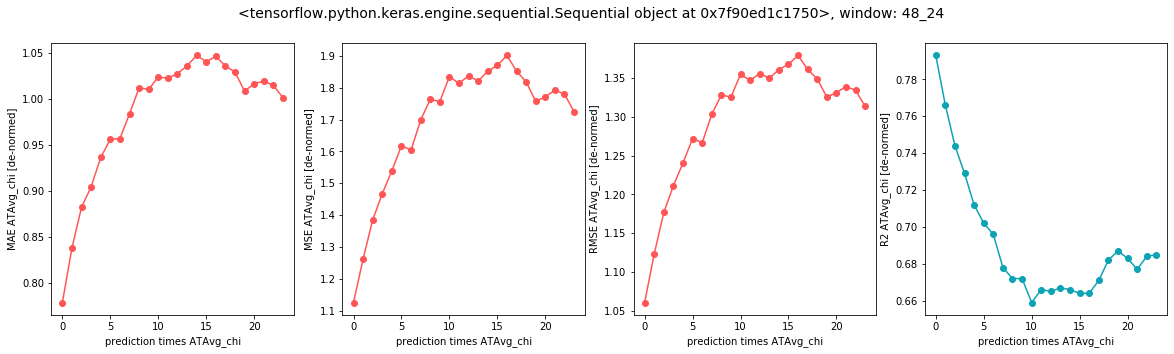

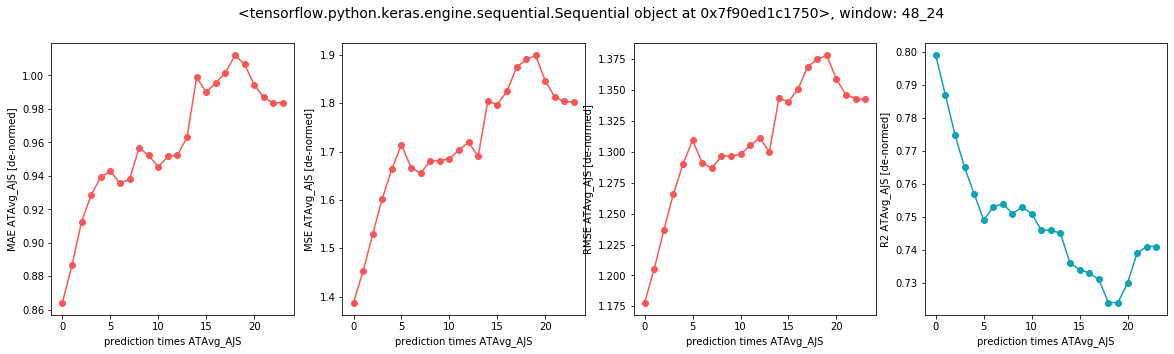

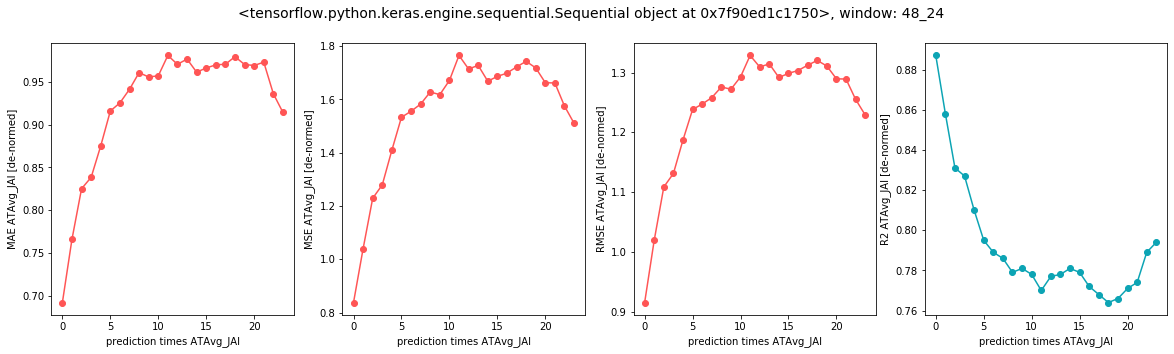

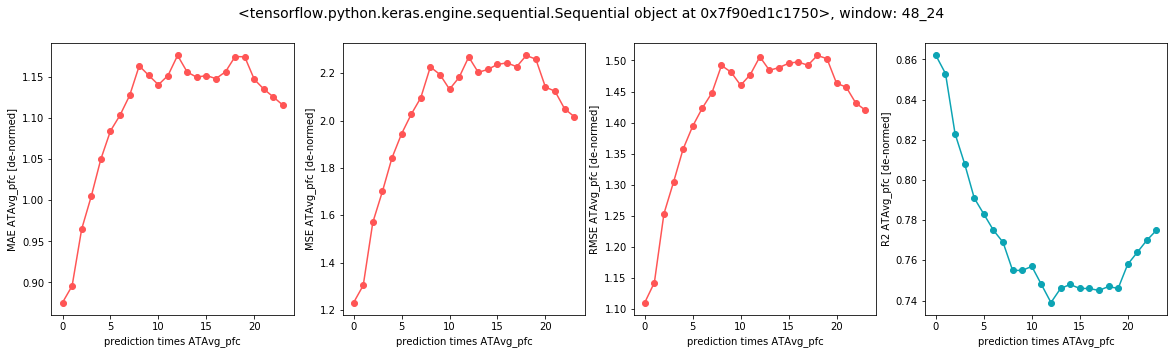

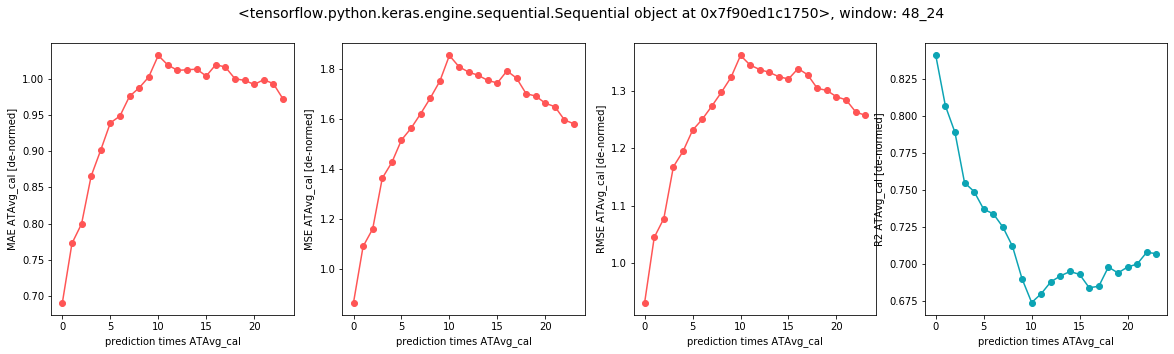

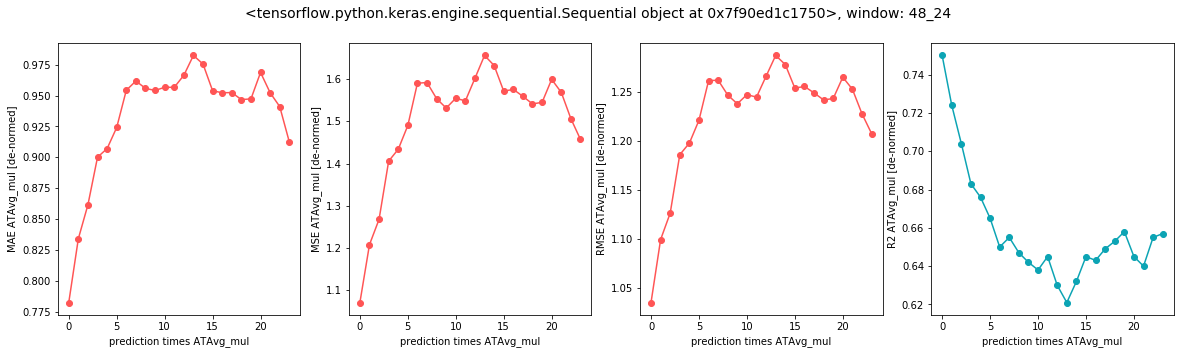

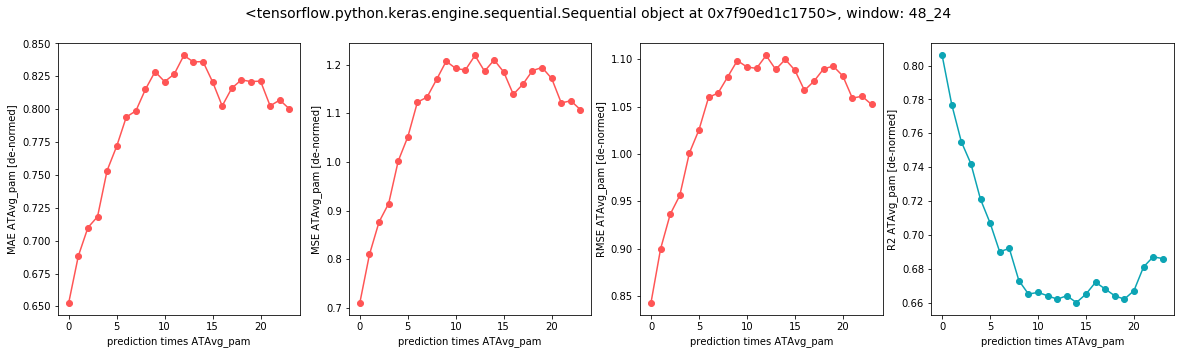

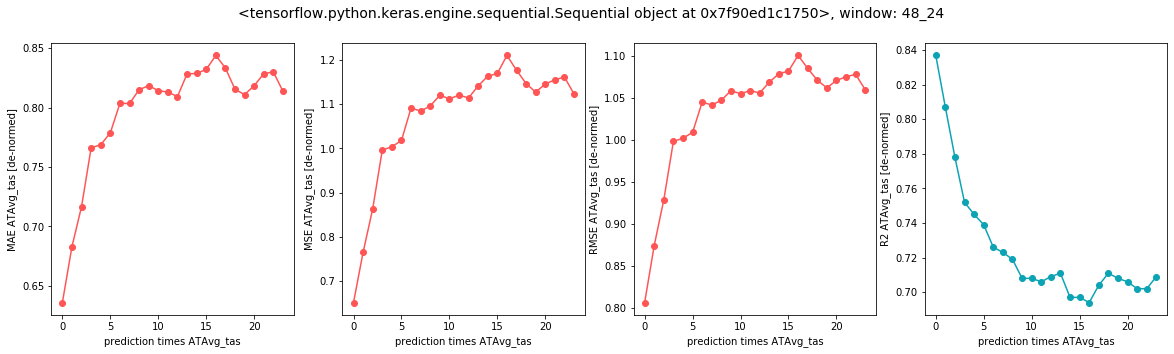

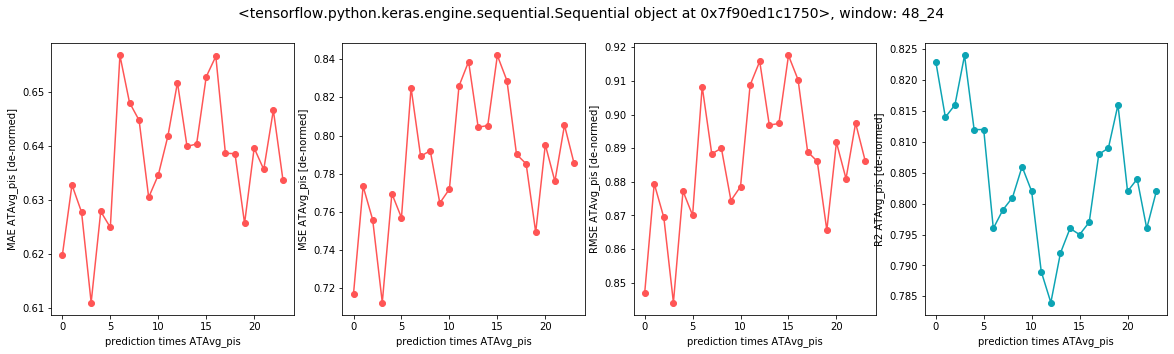

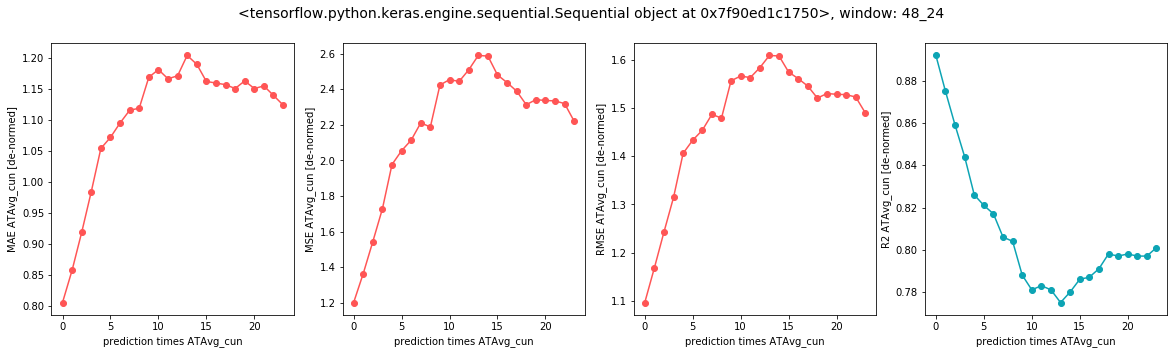

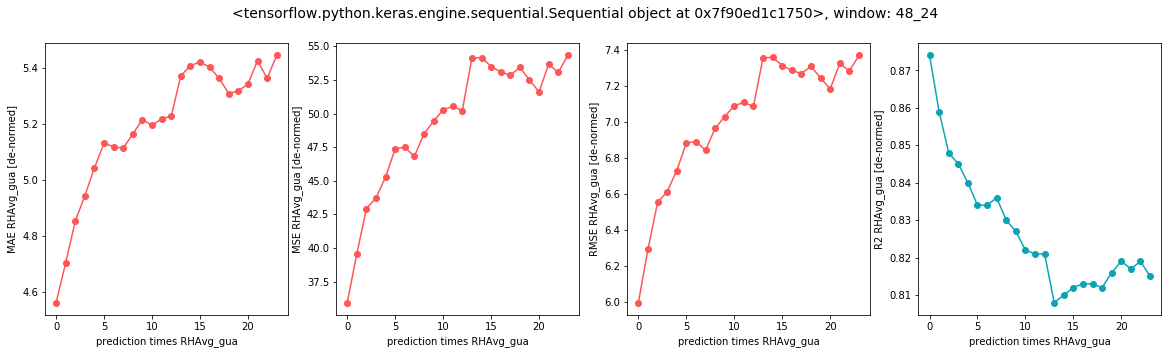

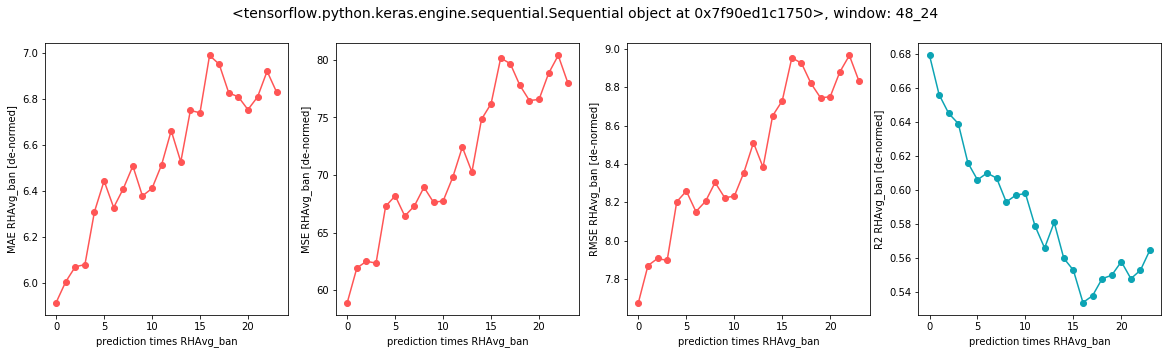

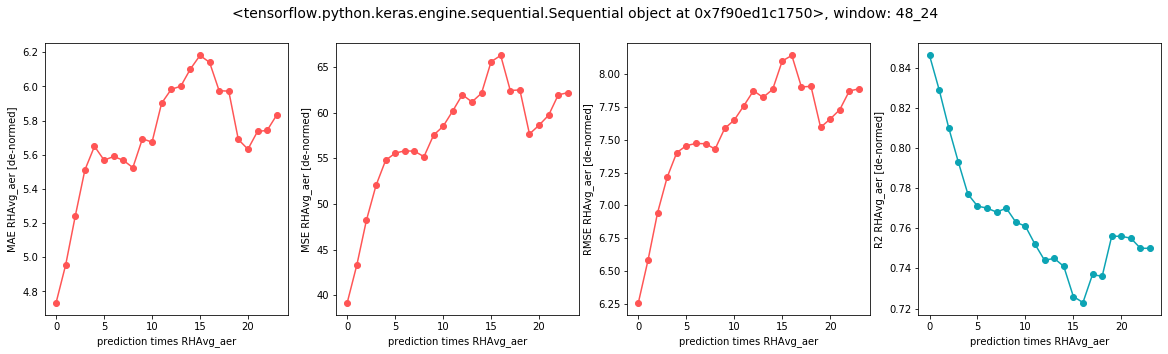

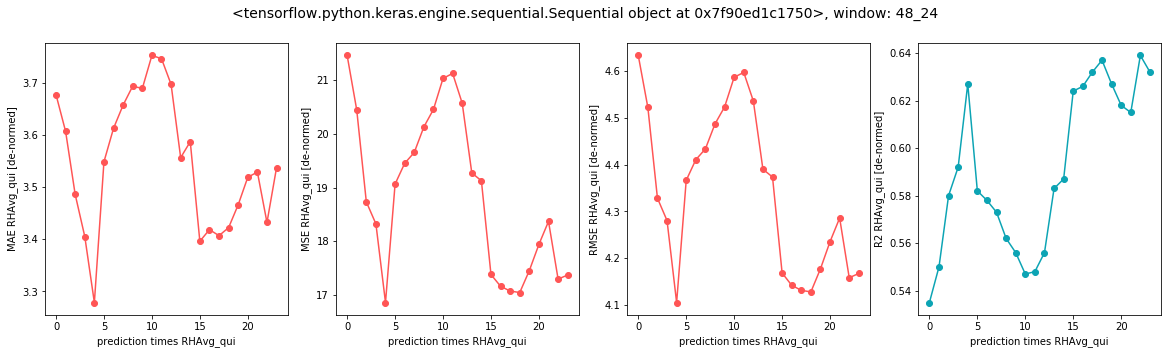

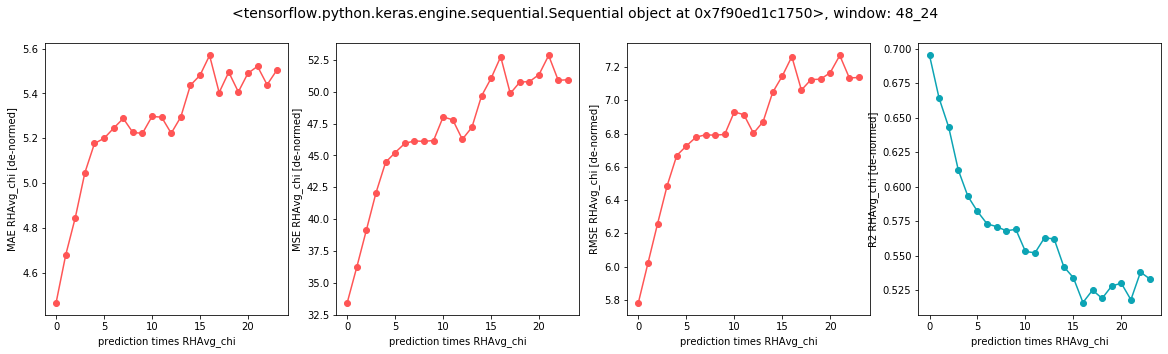

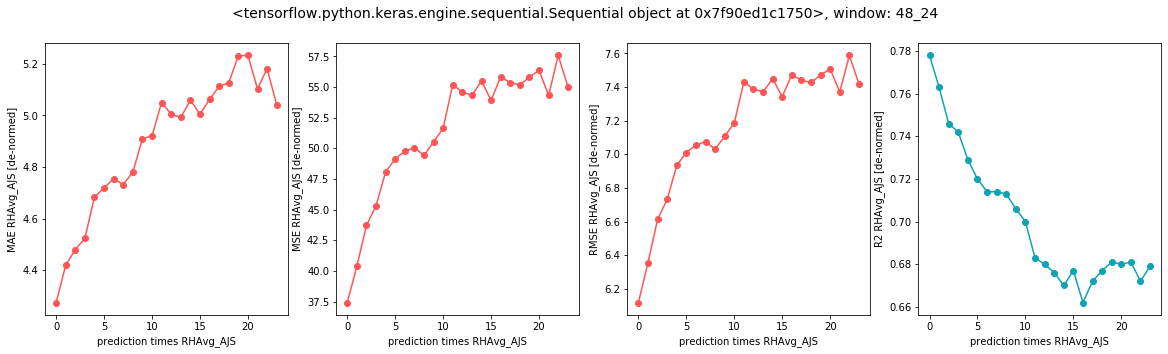

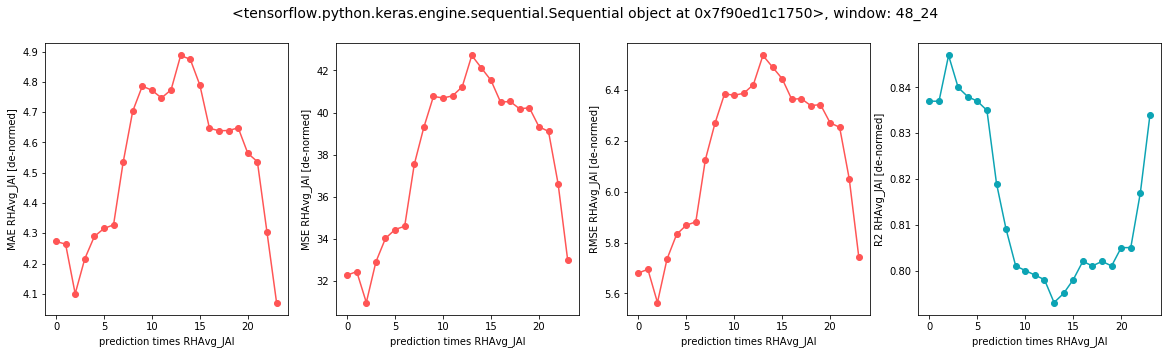

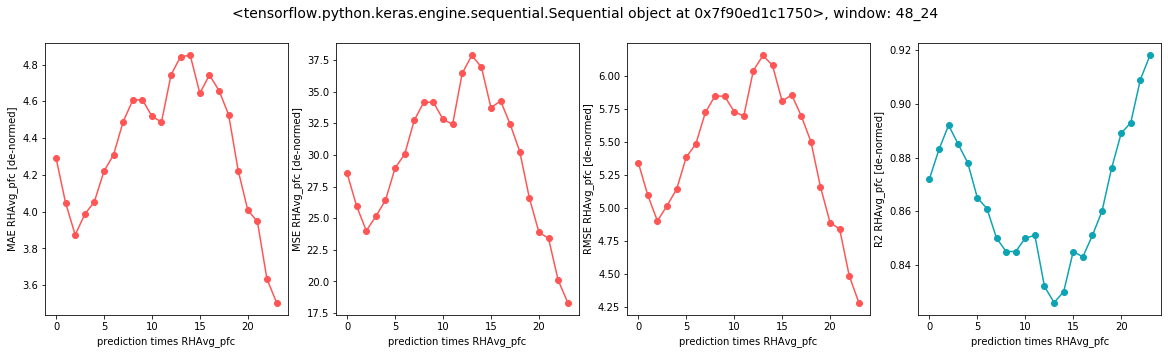

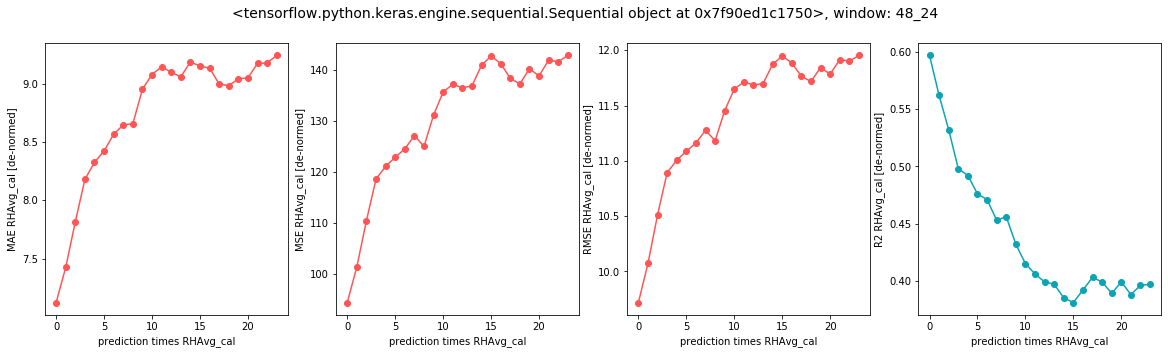

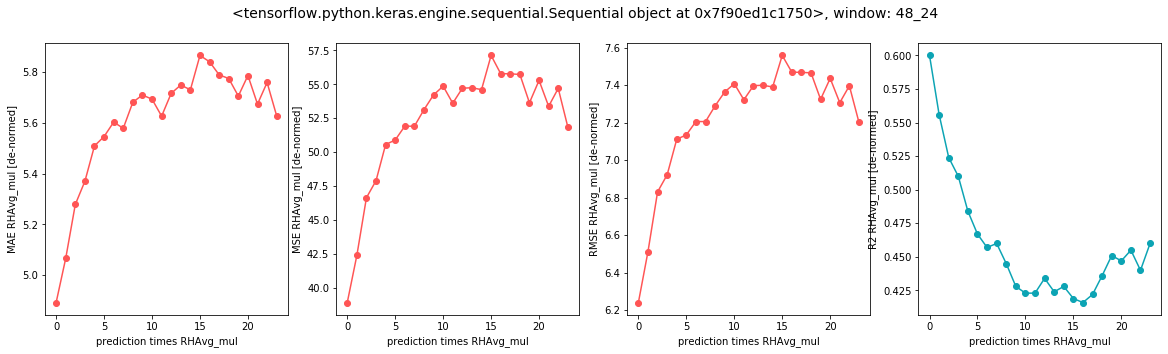

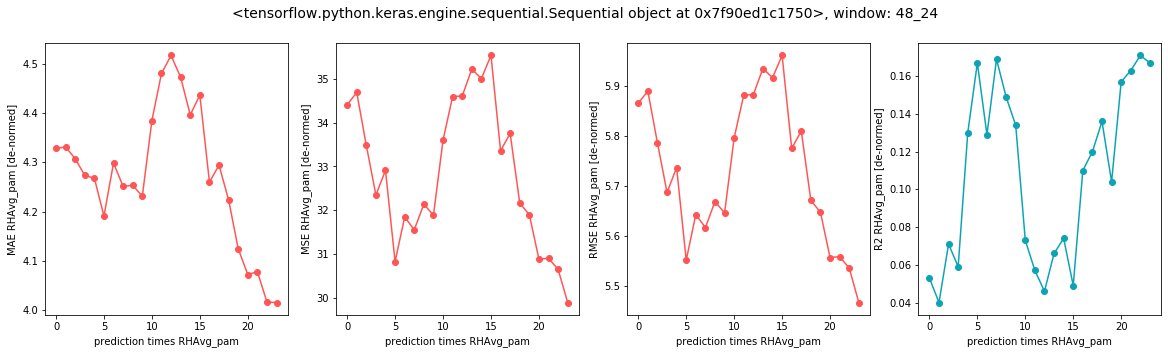

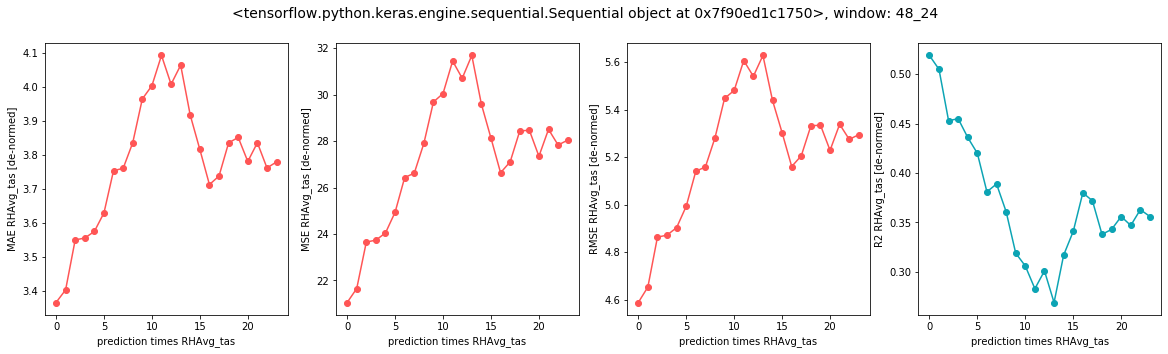

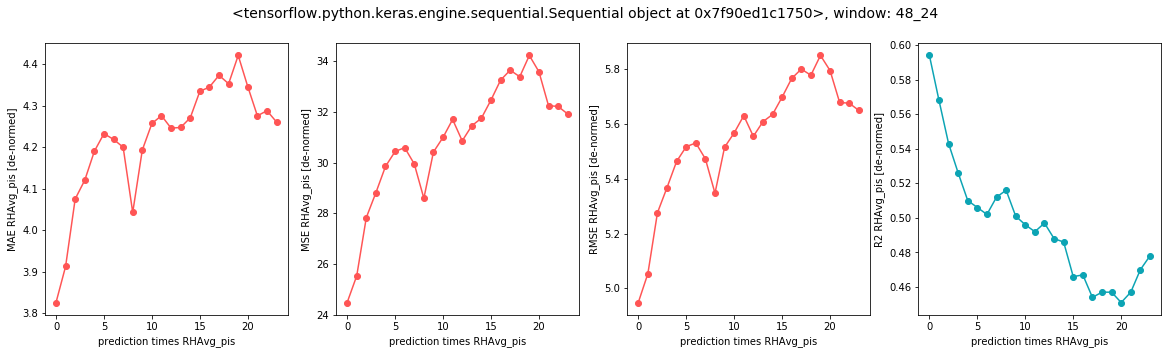

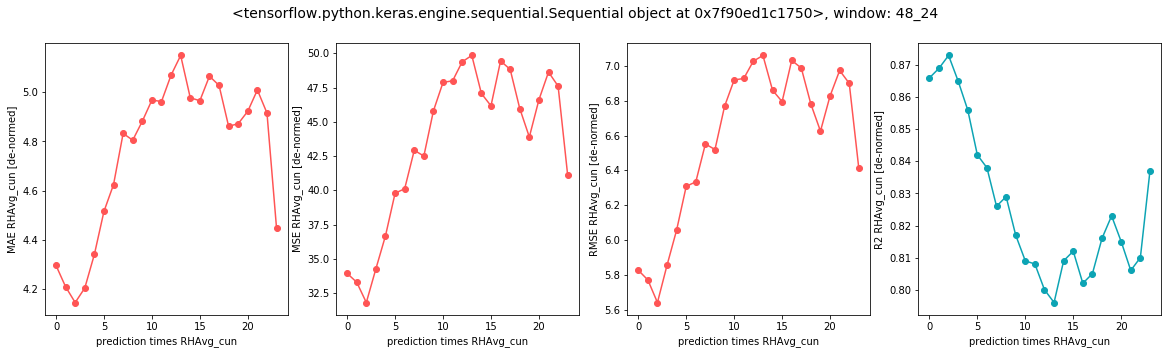

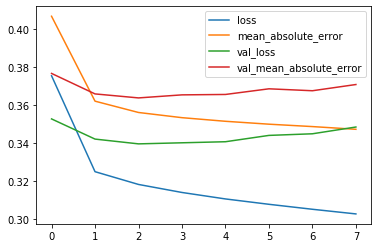

In [26]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=True)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 2 LSTM layers

323/323 [==============================] - 3s 10ms/step - loss: 0.3605 - mean_absolute_error: 0.3765
CPU times: user 27min 27s, sys: 4min 29s, total: 31min 56s
Wall time: 17min 22s


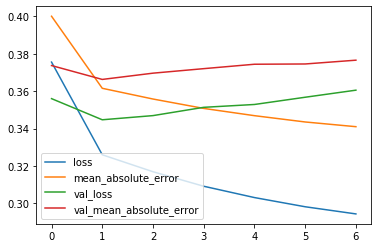

In [28]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.keras.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm2-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 3 LSTM layers

323/323 [==============================] - 4s 13ms/step - loss: 0.3650 - mean_absolute_error: 0.3778
CPU times: user 37min 4s, sys: 5min 53s, total: 42min 58s
Wall time: 25min 10s


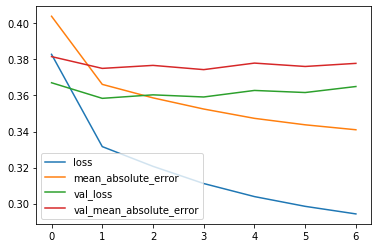

In [29]:
%%time
### RNN
print(f'RNN')
multi_val_performance = {}
multi_performance = {}
r2 ={}

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history= compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm3-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm3-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

### 4 LSTM layers

323/323 [==============================] - 4s 14ms/step - loss: 0.3716 - mean_absolute_error: 0.3822
CPU times: user 39min 57s, sys: 6min 24s, total: 46min 22s
Wall time: 26min 26s


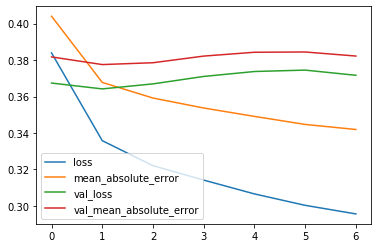

In [32]:
%%time
### RNN
print(f'RNN')
multi_val_performance = {}
multi_performance = {}
r2 ={}

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=True),
    tf.keras.layers.LSTM(batch_size, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history= compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'mean',plot=False)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm4-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')
per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm4-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')